In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from tqdm import tqdm
import spacy
nlp=spacy.load('en_core_web_sm')
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [2]:
df=pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='latin',header=None,on_bad_lines='skip')
df.rename(columns={0:'labels',5:'tweet'},inplace=True)
df.drop(columns=[1,2,3,4],axis=1,inplace=True)

In [3]:
df['labels']=df['labels'].replace(4,1)
df=df.sample(frac=1)
df=df.head(5000)
df.head()

,labels,tweet
499499,0,gd morning tweets! Today is my last day in Bal...
183378,0,I think the strange fluid and weird noises com...
1413559,1,Robin is awesome
539042,0,ugh i suck at theater i wish i can just sing h...
674691,0,@yojanellee i know huh . and school starts on ...


# Data PreProcessing

In [4]:
df['tweet'].values[0]

'gd morning tweets! Today is my last day in Bali..    i dun think i can leave. Sobss'

In [5]:
def get_word_len(tweet):
    return len(tweet.split(' '))

def get_chars_len(tweet):
    return len(tweet)

def preprocess(tweet):
    
    tweet=tweet.lower()
    tweet=re.sub(r"http\S+|www|S+|https\S+",'',tweet,flags=re.MULTILINE)
    tweet=re.sub(r"@\w+",'',tweet)
    tweet=re.sub(r"^\w\s#",'',tweet)
    tokens=[ twt.lemma_  for twt in nlp(tweet)]
    tokens=[token for token in tokens  if token not in stopwords.words('english')]
    tokens=[token for token in tokens if len(token)>1]
    preprocess_tweet=' '.join(tokens)
    
    return preprocess_tweet
    

In [6]:
df['clean_tweet']=[preprocess(twt) for twt in tqdm(df['tweet'],position=0,leave=True)]
df['tweet_words_len']=df['clean_tweet'].apply(get_word_len)
df['tweet_chars_len']=df['clean_tweet'].apply(get_chars_len)

100%|██████████| 5000/5000 [00:56<00:00, 89.02it/s]


In [7]:
df.head()

,labels,tweet,clean_tweet,tweet_words_len,tweet_chars_len
499499,0,gd morning tweets! Today is my last day in Bal...,gd morning tweet today last day bali .. du...,16,65
183378,0,I think the strange fluid and weird noises com...,think strange fluid weird noise come fork mean...,13,73
1413559,1,Robin is awesome,robin awesome,2,13
539042,0,ugh i suck at theater i wish i can just sing h...,ugh suck theater wish sing usually sing would ...,10,57
674691,0,@yojanellee i know huh . and school starts on ...,know huh school start mnday hectic schedule na,8,46


In [8]:
positive_count=len(df[df['labels']==1])
negtive_count=len(df[df['labels']==0])

fig=px.pie(values=[positive_count,negtive_count],title='Distribution of Postive and Negtive Sentiment of the tweets',names=['Positive','Negtive'],
           hover_name=['Postive','Negtive'],opacity=.9,template='simple_white' )

fig.show()

In [9]:
from wordcloud import WordCloud

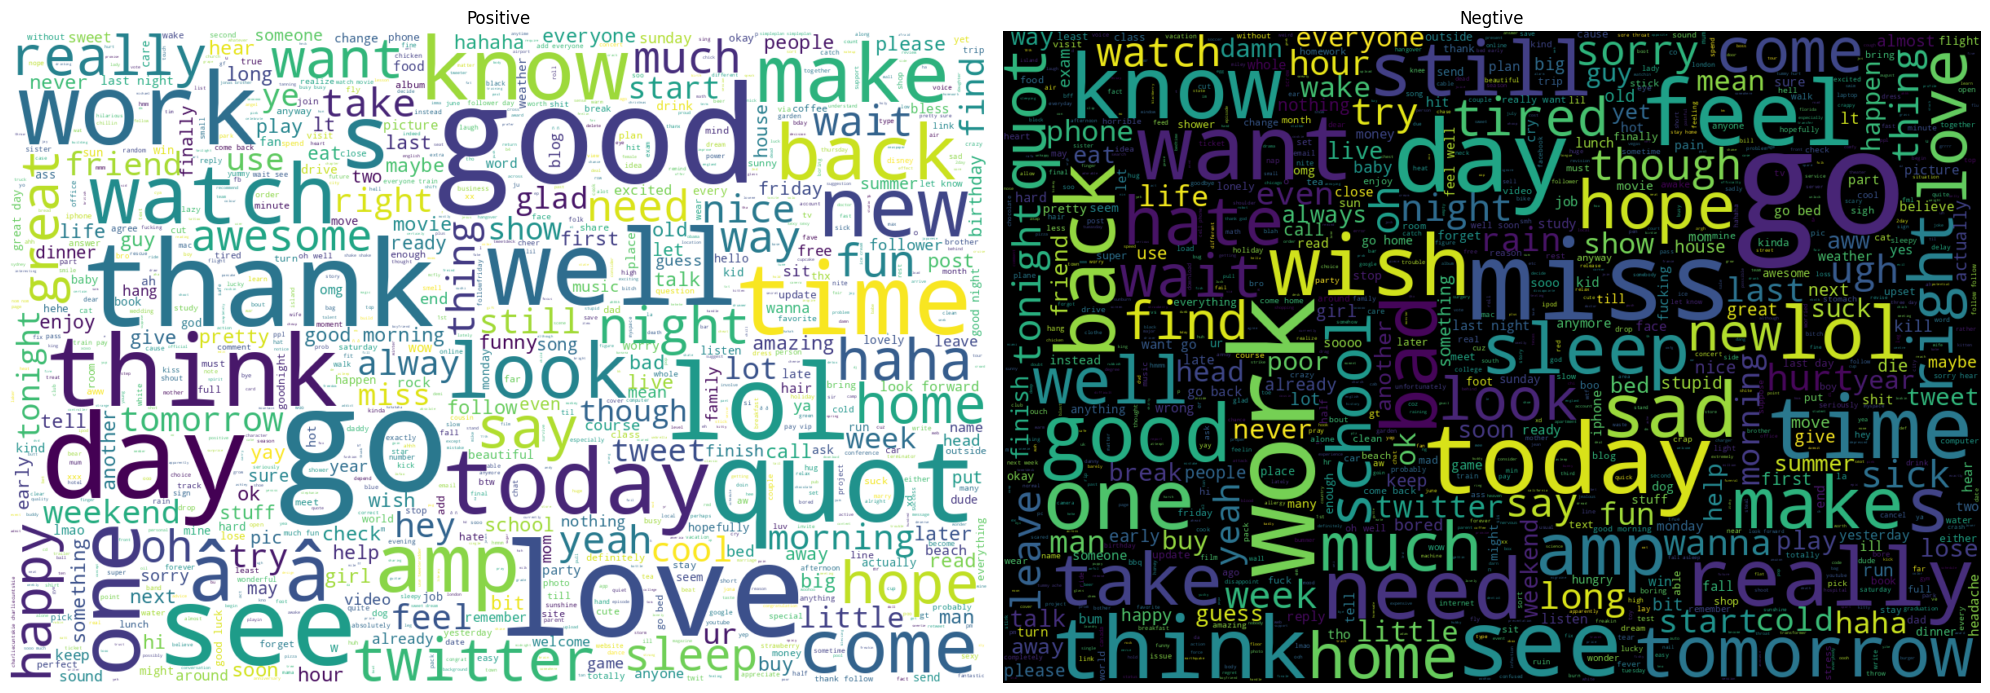

In [10]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
word_cloud1=WordCloud(width=1200,height=800,max_words=1000,max_font_size=180,background_color='white',
                      colormap='viridis').generate(' '.join(df[df['labels']==1]['clean_tweet']))
plt.imshow(word_cloud1,interpolation='bilinear')
plt.axis('off')
plt.title('Positive')

plt.subplot(1,2,2)
word_cloud2=WordCloud(width=1200,height=800,max_words=1000,colormap='viridis',background_color='Black',
                      max_font_size=180).generate(' '.join(df[df['labels']==0]['clean_tweet']))
plt.imshow(word_cloud2,interpolation='bilinear')
plt.axis('off')
plt.title('Negtive')


plt.tight_layout()
plt.show()


### Word_frequnacy Distrubution

In [11]:
fig_words=ff.create_distplot([df[df['labels']==1]['tweet_words_len'] ,df[df['labels']==0]['tweet_words_len']],
                                 ['Postive','Negtive'],bin_size=25,show_hist=False,show_rug=False)

fig_chars=ff.create_distplot([df[df['labels']==1]['tweet_chars_len'],df[df['labels']==0]['tweet_chars_len']],
                             ['Postive','Negtive'],bin_size=25,show_hist=False,show_rug=False)

fig_words.update_layout(title='Distribution of Words count',xaxis_title='No of Words',yaxis_title='Frequncy')
fig_chars.update_layout(title='Distribution of Chars count',xaxis_title='No of Chars',yaxis_title='Frequncy')

fig=make_subplots(rows=1,cols=2,subplot_titles=['Word Count','Char Count'])
fig.add_trace(fig_words['data'][0],row=1,col=1)
fig.add_trace(fig_words['data'][1],row=1,col=1)
fig.add_trace(fig_chars['data'][0],row=1,col=2)
fig.add_trace(fig_chars['data'][1],row=1,col=2)

fig.update_layout(title_text='Distribustion plots for Words  and Characters Count for tweets',showlegend=True,font=dict(family='Arial',size=15,color='black'))
fig.show()

# SPliting The Dataset

In [12]:
x_train,x_test,y_train,y_test=train_test_split(df['clean_tweet'],df['labels'],test_size=0.2,random_state=42)
x_test,x_val,y_test,y_val=train_test_split(x_test,y_test,test_size=0.5,random_state=42)

fig=px.pie(values=[len(x_train),len(x_test),len(x_val)],title='Distribution of Training and Test Valdation Tweet',names=['Training','Testing','Valdidation']
           ,hover_name=['Training','Testing','Valdidation'],opacity=0.9,template='simple_white')

fig.show()

In [13]:
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout

import warnings 
warnings.filterwarnings('ignore')

2024-08-27 10:41:35.706786: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 10:41:35.706921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 10:41:35.849242: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### 1.Neural Network | CounterVectorization() | OneHotEncoding

In [14]:
vec=CountVectorizer(binary=True)

vec=vec.fit(df['clean_tweet'])
enc_tweet=vec.fit_transform(df['clean_tweet']).toarray()

x_train,x_test,y_train,y_test=train_test_split(enc_tweet,df['labels'],test_size=.2,random_state=42)
x_test,x_val,y_test,y_val=train_test_split(x_test,y_test,test_size=0.5)


In [15]:
print('x_train shape :',x_train.shape)
print('y_train shape :',y_train.shape)
print('x_test shape :',x_test.shape)
print('y_test shape :',y_test.shape)
print(enc_tweet.shape[1])

x_train shape : (4000, 7750)
y_train shape : (4000,)
x_test shape : (500, 7750)
y_test shape : (500,)
7750


In [16]:
epochs_=2
batch_size_=32

In [17]:
model=Sequential()

model.add(Dense(512, activation='relu',input_shape=(enc_tweet.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128 ,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32 ,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


history_1=model.fit(x_train,y_train,epochs=epochs_,batch_size=batch_size_,validation_data=(x_val,y_val))

Epoch 1/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5302 - loss: 0.6881 - val_accuracy: 0.6680 - val_loss: 0.6239
Epoch 2/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7617 - loss: 0.5421 - val_accuracy: 0.6980 - val_loss: 0.6068


In [18]:
model.evaluate(x_test,y_test)
history_1.history

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7167 - loss: 0.5739


{'accuracy': [0.565750002861023, 0.7667499780654907],
 'loss': [0.6775878667831421, 0.5236225724220276],
 'val_accuracy': [0.6679999828338623, 0.6980000138282776],
 'val_loss': [0.6238533854484558, 0.6068212389945984]}

#### 2.Neural Network | CountVectorization

In [19]:
vec=CountVectorizer(binary=False)
vec.fit(df['clean_tweet'])

enc_tweet=vec.fit_transform(df['clean_tweet']).toarray()

x_train,x_test,y_train,y_test=train_test_split(enc_tweet,df['labels'],test_size=.2,random_state=42)
x_test,x_val,y_test,y_val=train_test_split(x_test,y_test,test_size=0.5)


model=Sequential()
model.add(Dense(512,activation='relu',input_shape=(enc_tweet.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


history_2=model.fit(x_train,y_train,epochs=epochs_,batch_size=batch_size_,validation_data=(x_val,y_val))
#model_history_2=model.fit(x_train,y_train,epochs=epochs_,batch_size=batch_size_,validation_data=(x_val,y_val))

Epoch 1/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5472 - loss: 0.6862 - val_accuracy: 0.6700 - val_loss: 0.6249
Epoch 2/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7593 - loss: 0.5205 - val_accuracy: 0.6480 - val_loss: 0.6587


In [20]:
model.evaluate(x_test,y_test)
history_2.history

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6675 - loss: 0.6261


{'accuracy': [0.581250011920929, 0.7674999833106995],
 'loss': [0.6693336367607117, 0.5072584748268127],
 'val_accuracy': [0.6700000166893005, 0.6480000019073486],
 'val_loss': [0.6248687505722046, 0.6587207913398743]}

In [21]:
print('x_train shape :',x_train.shape)
print('y_train shape :',y_train.shape)
print('x_test shape :',x_test.shape)
print('y_test shape :',y_test.shape)
print(enc_tweet.shape[1])

x_train shape : (4000, 7750)
y_train shape : (4000,)
x_test shape : (500, 7750)
y_test shape : (500,)
7750


### 3.Neural Network| Tf_IDF()

In [22]:
vec=TfidfVectorizer()
vec.fit(df['clean_tweet'])

enc_tweet=vec.fit_transform(df['clean_tweet']).toarray()

x_train,x_test,y_train,y_test=train_test_split(enc_tweet,df['labels'],test_size=.2,random_state=42)
x_test,x_val,y_test,y_val=train_test_split(x_test,y_test,test_size=0.5)


model=Sequential()
model.add(Dense(512,activation='relu',input_shape=(enc_tweet.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


history_3=model.fit(x_train,y_train,epochs=epochs_,batch_size=batch_size_,validation_data=(x_val,y_val))


Epoch 1/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5200 - loss: 0.6914 - val_accuracy: 0.6660 - val_loss: 0.6392
Epoch 2/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7286 - loss: 0.5589 - val_accuracy: 0.6800 - val_loss: 0.5756


In [23]:
model.evaluate(x_test,y_test)
history_3.history

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6658 - loss: 0.6025


{'accuracy': [0.5552499890327454, 0.7409999966621399],
 'loss': [0.6844046115875244, 0.545293390750885],
 'val_accuracy': [0.6660000085830688, 0.6800000071525574],
 'val_loss': [0.6392242908477783, 0.5755787491798401]}

#### 4. Neural Network | With index_based encoding

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
epochs_=5
batch_size_=32
seq_len=20
embedding_len_=50

In [26]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df['clean_tweet'])

word_index=tokenizer.word_index
index_word=tokenizer.index_word

enc_tweet=tokenizer.texts_to_sequences(df['clean_tweet'])
enc_tweet=pad_sequences(enc_tweet,maxlen=seq_len,padding='post')


x_train,x_test,y_train,y_test=train_test_split(enc_tweet,df['labels'],test_size=.2,random_state=42)
x_test,x_val,y_test,y_val=train_test_split(x_test,y_test,test_size=0.5)


model=Sequential()
model.add(Dense(512,activation='relu',input_shape=(enc_tweet.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


histery_4=model.fit(x_train,y_train,epochs=epochs_,batch_size=batch_size_,validation_data=(x_val,y_val))


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5061 - loss: 122.2765 - val_accuracy: 0.5400 - val_loss: 1.6504
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4982 - loss: 18.5843 - val_accuracy: 0.5320 - val_loss: 0.6946
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5091 - loss: 4.4195 - val_accuracy: 0.5400 - val_loss: 0.6923
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4966 - loss: 2.5659 - val_accuracy: 0.5280 - val_loss: 0.6928
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5009 - loss: 1.5422 - val_accuracy: 0.5440 - val_loss: 0.6926


In [27]:
model.evaluate(x_train,y_train)

histery_4.history

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5145 - loss: 0.6930


{'accuracy': [0.5065000057220459,
  0.5044999718666077,
  0.5,
  0.4975000023841858,
  0.49775001406669617],
 'loss': [79.40653991699219,
  13.626906394958496,
  3.430823564529419,
  2.113161087036133,
  1.3548753261566162],
 'val_accuracy': [0.5400000214576721,
  0.5320000052452087,
  0.5400000214576721,
  0.527999997138977,
  0.5440000295639038],
 'val_loss': [1.650350570678711,
  0.6945922374725342,
  0.6923357248306274,
  0.6928150057792664,
  0.6926195025444031]}

#### 4. Neural Network | With Embeddings

In [28]:
from tensorflow.keras.layers import Embedding,Flatten,Dense
from tensorflow.keras.optimizers import Adam

In [29]:
model=Sequential()

model.add(Embedding(input_dim=len(word_index)+1 ,output_dim=embedding_len_ ,input_length=seq_len))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=.001),metrics=['accuracy'])

history_5=model.fit(x_train,y_train,epochs=epochs_,batch_size=batch_size_,validation_data=(x_val,y_val))

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5090 - loss: 0.6926 - val_accuracy: 0.5900 - val_loss: 0.6626
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7581 - loss: 0.5614 - val_accuracy: 0.6600 - val_loss: 0.6232
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9459 - loss: 0.1781 - val_accuracy: 0.6600 - val_loss: 0.8046
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9808 - loss: 0.0584 - val_accuracy: 0.6260 - val_loss: 1.0484
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9890 - loss: 0.0345 - val_accuracy: 0.6560 - val_loss: 1.1014


In [30]:
model.evaluate(x_train,y_train)

history_5.history

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9940 - loss: 0.0169


{'accuracy': [0.5264999866485596,
  0.7684999704360962,
  0.9432500004768372,
  0.9797499775886536,
  0.9865000247955322],
 'loss': [0.6894838809967041,
  0.5126399993896484,
  0.16457599401474,
  0.05693937838077545,
  0.0352170355618],
 'val_accuracy': [0.5899999737739563,
  0.6600000262260437,
  0.6600000262260437,
  0.6259999871253967,
  0.656000018119812],
 'val_loss': [0.6625858545303345,
  0.6231797933578491,
  0.8046047687530518,
  1.0484201908111572,
  1.1014204025268555]}

#### 5. Embedding + SimpleRNN

In [31]:
epochs_=5
batch_size_=32
seq_len=20
embedding_len_=50

In [32]:
from tensorflow.keras.layers import SimpleRNN

In [33]:
model=Sequential()
model.add(Embedding(input_dim=len(word_index)+1,output_dim=embedding_len_,input_length=seq_len))
model.add(SimpleRNN(units=100,dropout=0.2,return_sequences=True))
model.add(SimpleRNN(units=50))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
history_6=model.fit(x_train,y_train,epochs=epochs_,batch_size=batch_size_,validation_data=(x_val,y_val))

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5048 - loss: 0.7003 - val_accuracy: 0.5240 - val_loss: 0.6930
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5192 - loss: 0.6940 - val_accuracy: 0.5060 - val_loss: 0.6933
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5594 - loss: 0.6838 - val_accuracy: 0.5260 - val_loss: 0.6905
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5901 - loss: 0.6642 - val_accuracy: 0.5260 - val_loss: 0.6927
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6493 - loss: 0.6272 - val_accuracy: 0.5580 - val_loss: 0.7045


In [34]:
model.evaluate(x_test,y_test)
history_6.history

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5134 - loss: 0.7391


{'accuracy': [0.5042499899864197,
  0.5202500224113464,
  0.5584999918937683,
  0.5874999761581421,
  0.6552500128746033],
 'loss': [0.7011635899543762,
  0.693182110786438,
  0.6832418441772461,
  0.6646849513053894,
  0.6215229630470276],
 'val_accuracy': [0.5239999890327454,
  0.5059999823570251,
  0.5260000228881836,
  0.5260000228881836,
  0.5580000281333923],
 'val_loss': [0.6930455565452576,
  0.6933209300041199,
  0.6905361413955688,
  0.6927000880241394,
  0.7045259475708008]}

# 7. Embedding + LSTM

In [35]:
from tensorflow.keras.layers import LSTM

In [36]:
model=Sequential()
model.add(Embedding(input_dim=len(word_index)+1 ,output_dim=(embedding_len_),input_length=seq_len))
model.add(LSTM(units=100 ,dropout=0.2,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
history_7=model.fit(x_train,y_train,epochs=epochs_,batch_size=batch_size_,validation_data=(x_val,y_val))

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.4932 - loss: 0.6933 - val_accuracy: 0.5460 - val_loss: 0.6928
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5047 - loss: 0.6926 - val_accuracy: 0.5600 - val_loss: 0.6928
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5348 - loss: 0.6919 - val_accuracy: 0.6000 - val_loss: 0.6766
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7075 - loss: 0.5990 - val_accuracy: 0.6760 - val_loss: 0.5942
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7940 - loss: 0.4855 - val_accuracy: 0.6920 - val_loss: 0.6255


In [37]:
model.evaluate(x_test,y_test)
history_7.history

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6693 - loss: 0.6266


{'accuracy': [0.5005000233650208,
  0.5052499771118164,
  0.5669999718666077,
  0.7264999747276306,
  0.796750009059906],
 'loss': [0.6932347416877747,
  0.6927436590194702,
  0.689048707485199,
  0.5713974237442017,
  0.47287023067474365],
 'val_accuracy': [0.5460000038146973,
  0.5600000023841858,
  0.6000000238418579,
  0.6759999990463257,
  0.6919999718666077],
 'val_loss': [0.692801296710968,
  0.6927600502967834,
  0.6766204833984375,
  0.594199001789093,
  0.6255243420600891]}

# 8. Embedding | GRU | Gate Recurrent Unit

In [38]:
from tensorflow.keras.layers import GRU

In [39]:
epochs_=5
batch_size_=32
seq_len=20
embedding_len_=50

In [40]:
model=Sequential()
model.add(Embedding(input_dim=len(word_index)+1 ,output_dim=(embedding_len_),input_length=seq_len))
model.add(GRU(units=100 ,dropout=0.2,return_sequences=True))
model.add(GRU(units=50))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
history_8=model.fit(x_train,y_train,epochs=epochs_,batch_size=batch_size_,validation_data=(x_val,y_val))

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5003 - loss: 0.6933 - val_accuracy: 0.5420 - val_loss: 0.6929
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4972 - loss: 0.6931 - val_accuracy: 0.5440 - val_loss: 0.6927
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5031 - loss: 0.6931 - val_accuracy: 0.5420 - val_loss: 0.6922
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5001 - loss: 0.6931 - val_accuracy: 0.5420 - val_loss: 0.6919
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4916 - loss: 0.6935 - val_accuracy: 0.5480 - val_loss: 0.6926


In [41]:
model.evaluate(x_test,y_test)
history_7.history

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5451 - loss: 0.6927


{'accuracy': [0.5005000233650208,
  0.5052499771118164,
  0.5669999718666077,
  0.7264999747276306,
  0.796750009059906],
 'loss': [0.6932347416877747,
  0.6927436590194702,
  0.689048707485199,
  0.5713974237442017,
  0.47287023067474365],
 'val_accuracy': [0.5460000038146973,
  0.5600000023841858,
  0.6000000238418579,
  0.6759999990463257,
  0.6919999718666077],
 'val_loss': [0.692801296710968,
  0.6927600502967834,
  0.6766204833984375,
  0.594199001789093,
  0.6255243420600891]}

### 9.Embedding | LSTM | Birdirectional

In [42]:
from tensorflow.keras.layers import Bidirectional

In [43]:
model=Sequential()

model.add(Embedding(input_dim=len(word_index)+1 ,output_dim=embedding_len_,input_length=seq_len))
model.add(Bidirectional(LSTM(units=100,dropout=0.2,return_sequences=True)))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
history_9=model.fit(x_train,y_train,epochs=epochs_,batch_size=batch_size_,validation_data=(x_val,y_val))

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.5191 - loss: 0.6931 - val_accuracy: 0.5440 - val_loss: 0.6923
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5219 - loss: 0.6923 - val_accuracy: 0.5580 - val_loss: 0.6912
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5473 - loss: 0.6897 - val_accuracy: 0.6460 - val_loss: 0.6805
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6852 - loss: 0.6293 - val_accuracy: 0.6860 - val_loss: 0.5918
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7800 - loss: 0.5003 - val_accuracy: 0.6980 - val_loss: 0.6058


In [44]:
model.evaluate(x_test,y_test)
history_9.history

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6702 - loss: 0.6529


{'accuracy': [0.512499988079071,
  0.5202500224113464,
  0.5672500133514404,
  0.7077500224113464,
  0.7885000109672546],
 'loss': [0.6931036114692688,
  0.6920983195304871,
  0.6876729130744934,
  0.597430944442749,
  0.47885093092918396],
 'val_accuracy': [0.5440000295639038,
  0.5580000281333923,
  0.6460000276565552,
  0.6859999895095825,
  0.6980000138282776],
 'val_loss': [0.6922539472579956,
  0.6912233829498291,
  0.6804591417312622,
  0.5918062329292297,
  0.6057586073875427]}

### 10. Embedding | Bidirectional | GRU

In [45]:
model=Sequential()

model.add(Embedding(input_dim=len(word_index)+1 ,output_dim=embedding_len_,input_length=seq_len))
model.add(Bidirectional(GRU(units=100,dropout=0.2,return_sequences=True)))
model.add(Bidirectional(GRU(units=50)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
history_10=model.fit(x_train,y_train,epochs=epochs_,batch_size=batch_size_,validation_data=(x_val,y_val))

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.5088 - loss: 0.6932 - val_accuracy: 0.4560 - val_loss: 0.6940
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5179 - loss: 0.6922 - val_accuracy: 0.4880 - val_loss: 0.6925
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5698 - loss: 0.6885 - val_accuracy: 0.6360 - val_loss: 0.6797
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6771 - loss: 0.6617 - val_accuracy: 0.6320 - val_loss: 0.6343
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7667 - loss: 0.5223 - val_accuracy: 0.6880 - val_loss: 0.5885


In [46]:
model.evaluate(x_test,y_test)
history_10.history

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6614 - loss: 0.6344


{'accuracy': [0.5052499771118164,
  0.5262500047683716,
  0.5897499918937683,
  0.6897500157356262,
  0.7757499814033508],
 'loss': [0.6931765079498291,
  0.6919105648994446,
  0.6860875487327576,
  0.6411908864974976,
  0.5089132189750671],
 'val_accuracy': [0.4560000002384186,
  0.4880000054836273,
  0.6359999775886536,
  0.6320000290870667,
  0.6880000233650208],
 'val_loss': [0.6939687132835388,
  0.6925238966941833,
  0.6797034740447998,
  0.6343432068824768,
  0.5885028839111328]}

### BY Using Word2vec

In [47]:
epochs_=5
batch_size_=32
seq_len=20
embedding_len_=100

In [48]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

In [49]:
word2vec=Word2Vec(list(map(lambda x : word_tokenize(x) ,df['clean_tweet'])),
                 vector_size=embedding_len_,
                 workers=8,
                 min_count=1)

print('Vocbulary Size :',len(word2vec.wv.key_to_index))

Vocbulary Size : 7974


# Creating Embedding Matrix

In [50]:
embedding_matrix=np.zeros((len(word2vec.wv.key_to_index), embedding_len_))

for word ,token in tokenizer.word_index.items():
    if(word2vec.wv.__contains__(word)):
        embedding_matrix[token]=word2vec.wv.__getitem__(word)
        
print('Shape of Embedding Matrix :',embedding_matrix.shape)       

Shape of Embedding Matrix : (7974, 100)


## Train The Neural Network

In [51]:
from tensorflow.keras.layers import Conv1D,GlobalMaxPooling1D

In [52]:
 model=Sequential()

model.add(Embedding(input_dim=len(word2vec.wv.index_to_key),output_dim=embedding_len_,weights=[embedding_matrix],input_length=seq_len,trainable=False))
model.add(Conv1D(128,5,activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
history_11=model.fit(x_train,y_train,epochs=epochs_,batch_size=batch_size_,validation_data=(x_val,y_val))

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5036 - loss: 0.6960 - val_accuracy: 0.4600 - val_loss: 0.6964
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5214 - loss: 0.6922 - val_accuracy: 0.5260 - val_loss: 0.6924
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5029 - loss: 0.6942 - val_accuracy: 0.5120 - val_loss: 0.6937
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5139 - loss: 0.6944 - val_accuracy: 0.5020 - val_loss: 0.6940
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5113 - loss: 0.6926 - val_accuracy: 0.4660 - val_loss: 0.6979


In [53]:
model.evaluate(x_test,y_test)
history_11.history

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4587 - loss: 0.6988 


{'accuracy': [0.4970000088214874,
  0.5172500014305115,
  0.5102499723434448,
  0.5184999704360962,
  0.5084999799728394],
 'loss': [0.6963375210762024,
  0.6928756237030029,
  0.6933690905570984,
  0.6933179497718811,
  0.6925942301750183],
 'val_accuracy': [0.46000000834465027,
  0.5260000228881836,
  0.5120000243186951,
  0.5019999742507935,
  0.4659999907016754],
 'val_loss': [0.6964386701583862,
  0.6924103498458862,
  0.693730354309082,
  0.6939774751663208,
  0.6978597640991211]}